In [1]:
from data_handlers import StockHistDataHandler,ComputeSuite
from trade_env_v0 import trade_env

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras import layers
from tensorflow import keras 
from scipy.stats import norm, uniform
import tensorflow as tf
import numpy as np
%config Completer.use_jedi = False
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GRU, TimeDistributed, Input, Masking

from utilities.function_utilities import *

# Data Scope

In [3]:
data_handler = StockHistDataHandler()

In [4]:
ts_range = ["2019-01-15","2021-07-5"]
raw_data = data_handler.get_data(sql= """SELECT * from intraday_hist WHERE CAST([eff_date] as time) > 
CAST('9:30' as time) and CAST([eff_date] as time) < CAST('15:30' as time) and ticker='FB' order by eff_date asc""")
# _ = ComputeSuite.pct_return(all_data.loc[:,:,:])
# raw_price_data= raw_data.loc[:,["adj_close_price"],:]
raw_p_v_data = raw_data.loc[:,["adj_close_price","volume"],:]
raw_p_v_data = np.moveaxis(raw_p_v_data.values, [0,1],[1,0])
train_data = raw_p_v_data[:,:,~np.isnan(raw_p_v_data.sum(axis=0)[0])]
# train_data = train_data[::-1,:,:] # trading of snapchat


# Main & Target network`

In [3]:

def state_sampler(state_hist_buffer, indices):
    """
    given state history buffer and sample indices, return the data in the model input format
    """
    sampled_time_series = np.concatenate([state_hist_buffer[i][0] for i in indices],axis=0)
    sampled_current = np.concatenate([state_hist_buffer[i][1] for i in indices],axis=0)
    return [sampled_time_series,sampled_current]

def trade_model():
    
    ### timeseries sub_network
    input_layer = keras.layers.Input(shape=(None,2,))
    hidden_layer = keras.layers.GRU(20, activation="tanh",return_sequences = True, name="gru1")(input_layer)
    hidden_layer = keras.layers.GRU(20, activation = "tanh", return_sequences =False, name = "gru2")(hidden_layer)
    output_layer = keras.layers.Dense(2, activation="relu", name ="dense2")(hidden_layer)
    
    
    ### higher level vinalla neural network
    input2 = keras.layers.Input(shape = (3))
    concat = keras.layers.Concatenate()([output_layer, input2])
    h2 = keras.layers.Dense(20,activation = "relu")(concat)
    h2 = keras.layers.Dense(20,activation = "relu")(h2)
    h2 = keras.layers.Dense(20,activation = "relu")(h2)
    h2 = keras.layers.Dense(20,activation = "relu")(h2)
    out2 = keras.layers.Dense(5, activation = "linear")(h2)
     
    model = keras.Model(inputs = [input_layer, input2], outputs = [out2])
    return model


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
gru1 (GRU)                      (None, None, 20)     1440        input_1[0][0]                    
__________________________________________________________________________________________________
gru2 (GRU)                      (None, 20)           2520        gru1[0][0]                       
__________________________________________________________________________________________________
dense2 (Dense)                  (None, 2)            42          gru2[0][0]                       
_______________________________________________________________________________________

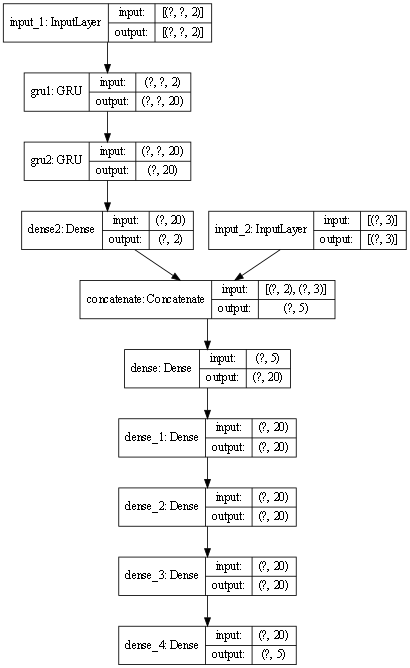

In [4]:

main_model = trade_model()
target_model = trade_model()
main_model.summary()
tf.keras.utils.plot_model(
    main_model, to_file='model.png', show_shapes=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=60
)

# Hyper/Macro settings

In [39]:


loss_function = keras.losses.Huber() # Huber goes to town!
# optimizer = keras.optimizers.Adam(learning_rate= 0.0000250,clipnorm=1.0)
# optimizer = keras.optimizers.RMSprop(learning_rate= 0.00015)



##### DQN RL Hyper-parameters #######
start_ep = 0
num_episode = 120000
update_target = 32    # update target network every # steps
gamma = 1   # reward decay
# episode_idx = 0 # turned off
exploring_state_boundary = 5000 # 1. explore boundary, 2. explore sub optimal
exploring_state_sub_opt = 10000
num_of_action = 5   # number of action is limited to sell 0,1,2,3,4 shares per minute
epsilon = 0.1  # exploration geedy parameter
prob_of_smaller_interval = 0.3 # greedy parameter for smaller scenario
time_elapsed = 0 # starting index, careful with this!

oversale_punish = 0.005
reward_curve = []
TWAP = []
model_average = []



##### Replay-buffer Hyper-parameters #######
max_buffer_length = 10000    
action_history = []
reward_history = []
state_history = []
state_next_history = []
done_history = []
update_after_action = 4
batch_size = 64
        



# ########## learning rates

# step = tf.Variable(0, trainable=False)
# boundaries = [exploring_state_boundary, exploring_state_sub_opt]
# values = [0.006, 0.003, 0.0001]
# learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)
# learning_rate = learning_rate_fn(step)
# optimizer = keras.optimizers.Adam(learning_rate= learning_rate)


###
optimizer = keras.optimizers.Adam(learning_rate= 0.00005,clipnorm=1.0)



# Load base model

In [54]:
previous_model = keras.models.load_model("onlygoodone2")

main_model.set_weights(previous_model.get_weights())
target_model.set_weights(previous_model.get_weights())

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\DevelopmentTools\envs\quant\lib\site-packages\tensorflow\python\keras\backend.py", line 4354, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "C:\DevelopmentTools\envs\quant\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\DevelopmentTools\envs\quant\lib\site-packages\tensorflow\python\keras\backend.py", line 4354, in <genexpr>
    ta.write(time, out) for ta, out in zip(ou

### Examine base model if you will

In [36]:
ep = 10022
random_idx = 1290

env = trade_env(data = train_data[:,:,random_idx+1:]/train_data[:,:,random_idx+20,None])
# env.current_price= 
# env.inventory = 7
# env.time_remain = 7
state1 = env.start()
main_model.predict(state1)




array([[1.4640391e-05, 3.8236938e-04, 3.3223070e-04, 4.5272522e-04,
        1.0121614e-04]], dtype=float32)

# Train double GRU-DQN

In [5]:
start_ep = 10000

print(f"Training from ep {start_ep}")
for ep in range(start_ep, num_episode+start_ep):
    
    
    ######## 1. training cache  ############

    episode_reward = []
    

    ######## 2. load environment  ############
    
    random_idx = np.random.randint(low=1, high = 160000) # sample from environment   
    data_slice =  train_data[:,:,random_idx+1:] #/train_data[:,:,random_idx+20,None] # todo: +20 is hard coded to normalize the trade start pric
    
    max_price_chg = np.max(np.abs(np.diff(data_slice[0,0,:32]))) # take out extreme environment (price pattern)
    max_volume_chg = np.max(np.abs(np.diff(data_slice[1,0,:32])))# take out extreme environment (volume pattern)
    if max_price_chg>0.5 or max_volume_chg>55000: # tody criteria hard coded for SNAP
        continue 
        
    data_slice_normalized = train_data[:,:,random_idx+1:] /train_data[:,:,random_idx+20,None]   
    env = trade_env(data =data_slice_normalized) # initialized environment
    
    ######## 3.1 modify environment for small episode exploration ############
    # at begining stage of training or later statge with certain probability, modify the remaining time 
    # for the episode (make it very small)
    if prob_of_smaller_interval>np.random.rand(1)[0] or ep<exploring_state_boundary: #   
        env.time_remain = np.random.choice([2,3,4])
    else:
        env.time_remain = 10
        
    current_state = env.start()
    is_full_episode = True if env.time_remain ==10 else False
    
    
    ######## 3.2 exploration-stage and epsilon greedy  ############
    # at begining stage of training or later statge with certain probability, take sub-optimal actions 
    while True:
        time_elapsed+=1
        if time_elapsed%update_target ==0:
                target_model.set_weights(main_model.get_weights())
     
        if ep< exploring_state_sub_opt or epsilon>np.random.rand(1)[0]:
            action = np.random.choice(num_of_action)
           
        else:
            action = tf.argmax(main_model(current_state,training = False),axis=1).numpy()[0]
            
           
        ####### 4 take actions/save experience to reply buffer  ############
        
        next_state, reward, end_episode = env.step(action)
        action_history.append(action)
        reward_history.append(reward)
        state_history.append(current_state)
        state_next_history.append(next_state)
        done_history.append(end_episode)
        episode_reward.append(reward)
        
        ######## 5 train in the experience-replay buffer  ############
        
        if  len(action_history)>= batch_size and time_elapsed%update_after_action==0:
            
        
            indices = np.random.choice(np.arange(len(action_history)),batch_size) # sample # of record from buffer
            state_sample = state_sampler(state_history, indices) # sample state (both current and time series) with sate_sampler function
            state_next_sample = state_sampler(state_next_history, indices)
            reward_sample = np.array(reward_history)[indices]
            action_sample = np.array(action_history)[indices]
            done_sample = np.array(done_history)[indices]

            future_state_action_val = target_model.predict(state_next_sample)
            future_state_action_val[np.isnan(future_state_action_val)] = 0 # this is for the terminal state (nans)
            future_reward = tf.reduce_max(future_state_action_val,axis=1)
         
            G = reward_sample+gamma*future_reward #compute "True" future reward based on model (bootstrapped)
            mask = tf.one_hot(action_sample,num_of_action) # only train on the actions that are chosen
      
           
#             print(f"Act pre:{tf.reduce_sum(tf.multiply(main_model(state_sample),mask),axis=1)}")
            with tf.GradientTape() as tape:
                # Hijack gradient and customize the training process
                
                current_state_action_val = main_model(state_sample)
                current_reward = tf.reduce_sum(tf.multiply(current_state_action_val,mask),axis=1) # compute "Model" future reward
                loss = loss_function(G, current_reward)  
            grad = tape.gradient(loss, main_model.trainable_variables)
            optimizer.apply_gradients(zip(grad, main_model.trainable_variables))
         
#             print(f"Act target:{G}")
#             print(f"Act post:{tf.reduce_sum(tf.multiply(main_model(state_sample),mask),axis=1)}")

                
                
        ######## 6. set_state, clear buffer, and end episode  ############

        current_state = next_state
        if len(action_history)>max_buffer_length:
            del action_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del done_history[:1]
            del reward_history[:1]
        
        
        if end_episode:
            
            TWAP.append(env.TWAP)
            model_average.append(env.average_trade_price)
            if ep%100 ==0:
                print(ep)
            if ep%200==0:
                print("avg_reward: ",np.mean(reward_history),len(reward_history))
                
            
            break
 

        
        

# Test double GRU-DQN

In [1]:
#### fixed version

TWAP_test = []
model_average_test = []
for ep in range(5000):
    
    
    ######## training cache  ############
    ######################################

    episode_reward = []

    ######## load episode data ############
    ######################################
    random_idx = np.random.randint(low=1, high = 160000)
    
    data_slice =  train_data[:,:,random_idx+1:] #/train_data[:,:,random_idx+20,None] # todo: +20 is hard coded to normalize the trade start pric
    max_price_chg = np.max(np.abs(np.diff(data_slice[0,0,:32])))
    max_volume_chg = np.max(np.abs(np.diff(data_slice[1,0,:32])))
    if max_price_chg>0.5 or max_volume_chg>55000:
        continue
    data_slice_normalized = train_data[:,:,random_idx+1:] /train_data[:,:,random_idx+20,None]
        
    env = trade_env(data =data_slice_normalized)
    ######## modify environment for small episode exploration ############
    ######################################################################
    if prob_of_smaller_interval>np.random.rand(1)[0]:  
        env.time_remain = np.random.choice([2,3,4])
    else:
        env.time_remain = 10
        
    current_state = env.start()
    is_full_episode = True if env.time_remain ==10 else False
     
    ######## exploration-stage and epsilon greedy  ############
    ##########################################################
    while True:
        

        action = tf.argmax(main_model(current_state,training = False),axis=1).numpy()[0]
        print(action) # , main_model(current_state,training = False))
            
        next_state, reward, end_episode = env.step(action)
        current_state = next_state
      
        
        if end_episode:
            print(f"########{ep}##########")
            
            TWAP_test.append(env.TWAP)
            model_average_test.append(env.average_trade_price)
         
                
            break
 

        
        